<a href="https://colab.research.google.com/github/S1ink/Colabs/blob/main/supervisely-pc-transforms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install open3d

In [2]:
import os
import shutil
import json
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from google.colab import files

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import open3d as o3d

In [6]:
content = files.upload()
pnames = list(content.keys())
for f in tqdm(pnames):
    shutil.unpack_archive(f)
    print("\nUnpacked {}!".format(f))

Saving 566215_266254_2023-09-18 11_53_31.878.tar.gz to 566215_266254_2023-09-18 11_53_31.878.tar.gz


100%|██████████| 1/1 [00:00<00:00, 65.05it/s]


Unpacked 566215_266254_2023-09-18 11_53_31.878.tar.gz!


{'bbox': '#B009C3', 'none': 'gray'} {'none', 'bbox'}


Points Iteration: 100%|██████████| 8693/8693 [00:00<00:00, 187730.84it/s]

Points Iteration: 100%|██████████| 107849/107849 [00:00<00:00, 180379.76it/s]

Points Iteration: 100%|██████████| 7132/7132 [00:00<00:00, 200125.61it/s]

Points Iteration: 100%|██████████| 8058/8058 [00:00<00:00, 237632.11it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

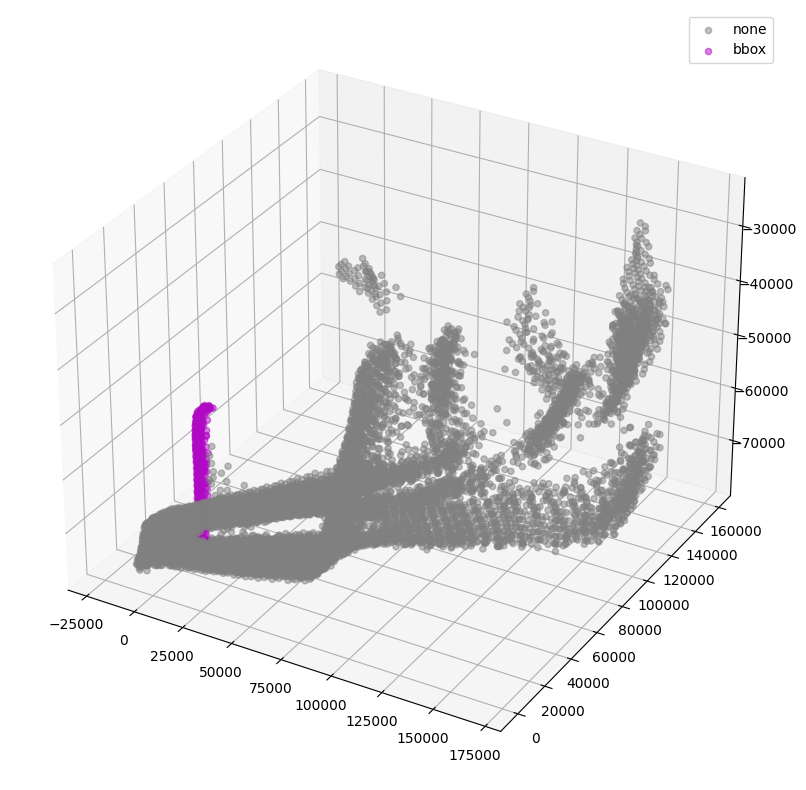

 14%|█▍        | 1/7 [00:00<00:03,  1.56it/s]

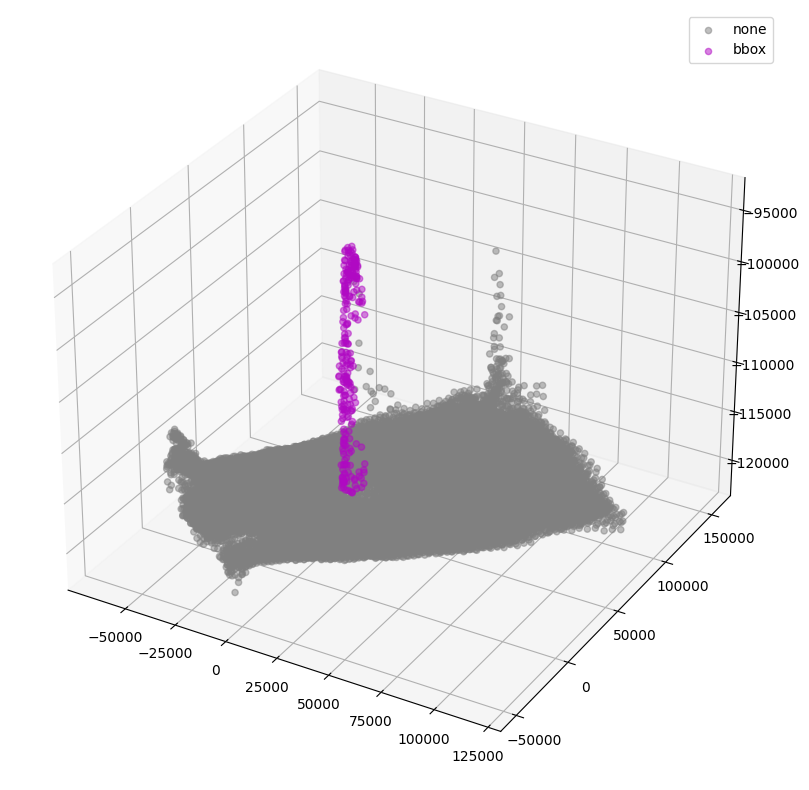

 29%|██▊       | 2/7 [00:01<00:04,  1.24it/s]

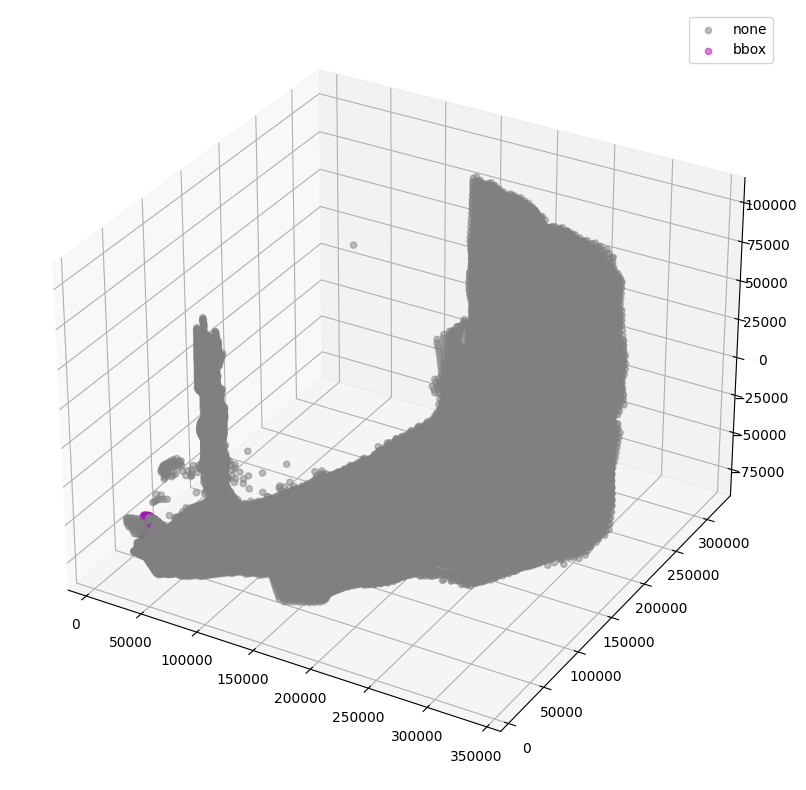

 43%|████▎     | 3/7 [00:06<00:10,  2.72s/it]

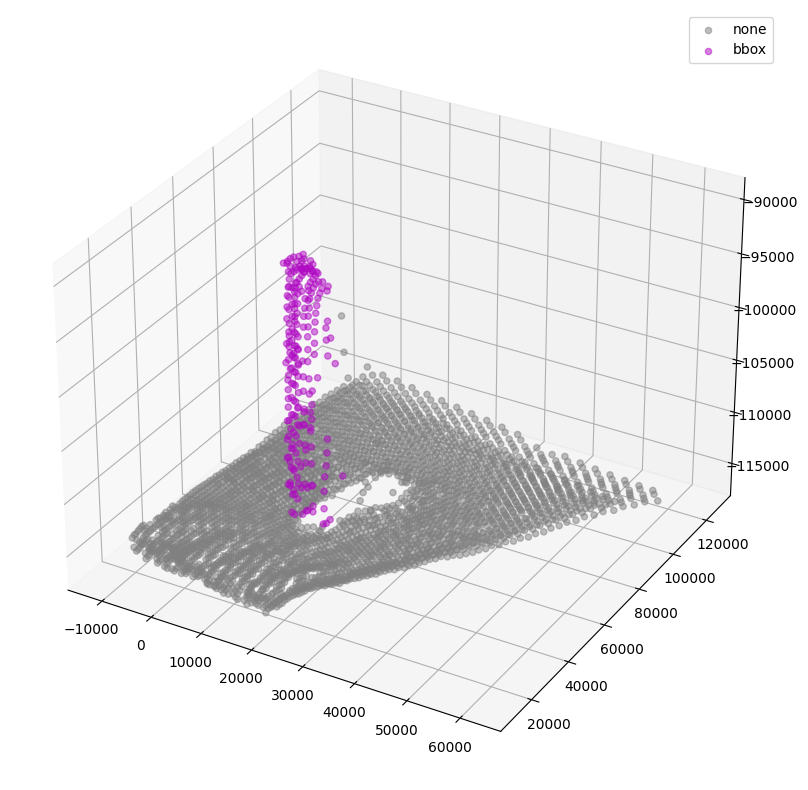

 57%|█████▋    | 4/7 [00:07<00:05,  1.83s/it]

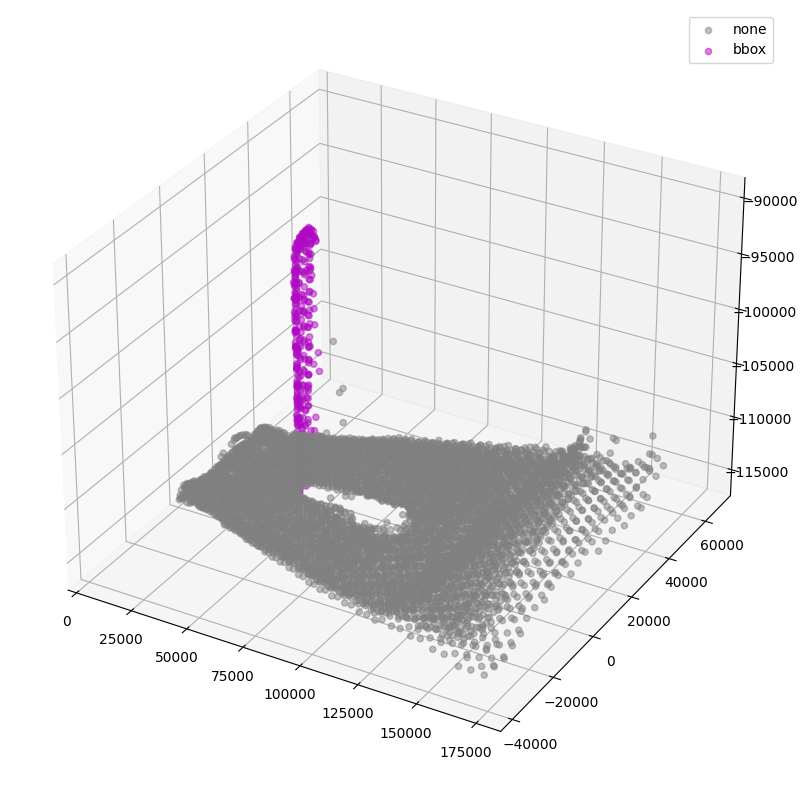

 71%|███████▏  | 5/7 [00:07<00:02,  1.37s/it]

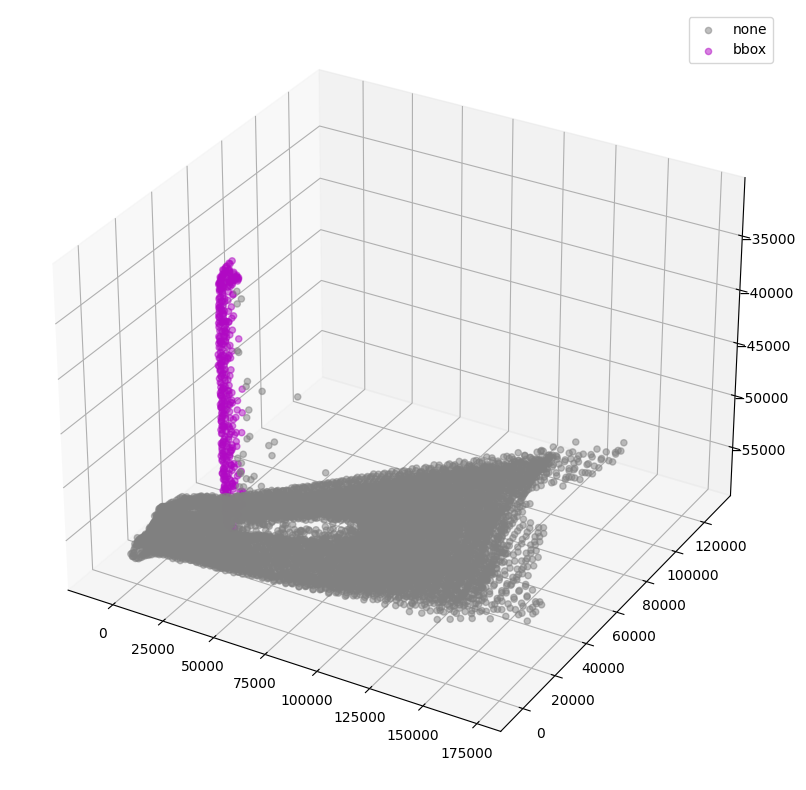

 86%|████████▌ | 6/7 [00:08<00:01,  1.12s/it]

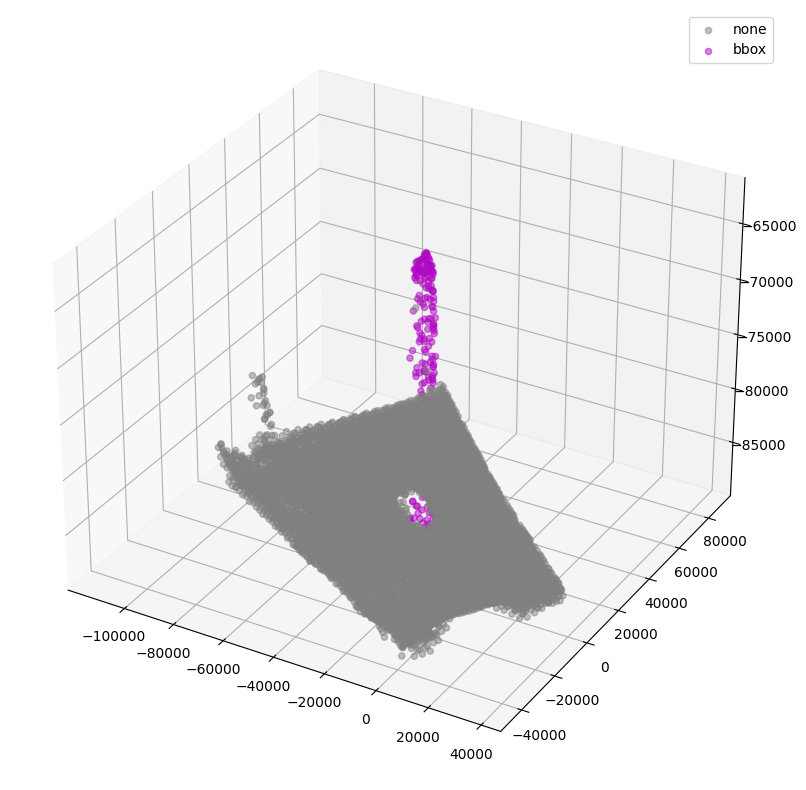

100%|██████████| 7/7 [00:09<00:00,  1.32s/it]


In [37]:
DS_BASE = "./dataset/"
KEY_MAP_JSON = DS_BASE + "key_id_map.json"
META_JSON = DS_BASE + "meta.json"

def _annotation(fname):
    return DS_BASE + "ds0/ann/{}".format(fname)
def _source(fname):
    return DS_BASE + "ds0/pointcloud/{}".format(fname)

def _basename(path):
    return path.split("/")[-1].split(".")[0]


with open(KEY_MAP_JSON) as json_file:
    keymap = json.load(json_file)

with open(META_JSON) as json_file:
    meta = json.load(json_file)   # have the metadata for all the classes and colors

class_colors = dict()
ALL_LABELS = set()
for c in meta["classes"]:
    label = c["title"]
    class_colors[label] = c["color"]
    ALL_LABELS.add(label)

# print(class_colors)

# print(meta)
# print(map)

point_sets = []
point_set_labels = []
point_set_1hot = []

DEFAULT_LABEL = "none"
class_colors[DEFAULT_LABEL] = "gray"
ALL_LABELS.add(DEFAULT_LABEL)

print(class_colors, ALL_LABELS)

annotations = glob(_annotation("*.pcd.json"))
for a in tqdm(annotations):
    source = _source(_basename(a) + ".pcd")
    # print("\n", source)
    if(os.path.exists(source)):
        with open(a) as json_file:
           a_data = json.load(json_file)    # have the configuration for the bounds

        pcd = o3d.io.read_point_cloud(source)
        pc_data = np.asarray(pcd.points)    # have all the points as numpy array

        # print(a_data)
        # print(pc_data.shape)

        # get dictionary of class : cuboid data for all cuboid annotations
        # loop through points - test agains all cuboids, if none, mark default class (parameter for this)
        # store list of classifications for all points

        objects = a_data["objects"]
        figures = a_data["figures"]     # list of annotation volume
        label_bounds = []
        for f in figures:
            if f["geometryType"] != "cuboid_3d":
                continue
            objkey = f["objectKey"]
            geo = f["geometry"]
            class_label = next(i for i in objects if i["key"] == objkey)["classTitle"]  # find the first dictionary with a matching "key":objkey pair --> use that dictionaries class label

            # print(objkey, "\n", geo)
            # print("\n", class_label)

            # extract cuboid bbox data
            origin = np.array(list(geo["position"].values()))
            scale = np.array(list(geo["dimensions"].values()))
            min = origin - scale / 2
            max = origin + scale / 2

            label_bounds.append((min, max, class_label))    # append tuple of min, max, label

        # print(label_bounds)

        set_labels = []
        for i, p in enumerate(tqdm(pc_data, "Points Iteration: ")):
            valid = False
            for l in label_bounds:
                if (l[0] <= p).all() and (p <= l[1]).all():
                    valid = True
                    set_labels.append(l[2])
                    break
            if not valid:
                set_labels.append(DEFAULT_LABEL)

        # print(set_labels)
        point_sets.append(pc_data)
        point_set_labels.append(set_labels)

# print(point_sets, point_set_labels)

def visualize_data(pc, labels):
    df = pd.DataFrame(
        data={
            "x": pc[:, 0],
            "y": pc[:, 1],
            "z": pc[:, 2],
            "label": labels
        }
    )
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection="3d")
    for label in ALL_LABELS:
        c_df = df[df["label"] == label]
        try:
            ax.scatter(
                c_df["x"], c_df["y"], c_df["z"], label=label, alpha=0.5, c=class_colors[label]
            )
        except IndexError:
            pass
    ax.legend()
    plt.show()

for i in tqdm(range(len(point_sets))):
    visualize_data(point_sets[i], point_set_labels[i])
